In [ ]:
!pip install kagglehub
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("Cornell-University/arxiv")

print("Path to dataset files:", path)

In [3]:
import json
import random
import pandas as pd

# Create a random subset of data

In [4]:
DATA_PATH = "/root/.cache/kagglehub/datasets/Cornell-University/arxiv/versions/213/arxiv-metadata-oai-snapshot.json"
sample_size = 250000  # Desired subset size
reservoir = []
count = 0

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        # Parse each JSON object (one paper per line)
        record = json.loads(line)
        count += 1

        # If the reservoir is not yet full, append directly
        if len(reservoir) < sample_size:
            reservoir.append(record)
        else:
            # Once full, replace elements randomly
            r = random.randint(0, count - 1)
            if r < sample_size:
                reservoir[r] = record

# 'reservoir' now contains a random subset of 'sample_size' records
print("Number of records in random subset:", len(reservoir))

Number of records in random subset: 250000


# Load subset

In [5]:
subset_file = 'arxiv_subset.json'

with open(subset_file, 'w', encoding='utf-8') as f_out:
    for record in reservoir:
        f_out.write(json.dumps(record) + '\n')
        
print(f"Subset file saved: {subset_file}")

Subset file saved: arxiv_subset.json


In [6]:
# 3. (Optional) Load and verify the saved subset
subset_data = []
with open(subset_file, 'r', encoding='utf-8') as f_in:
    for line in f_in:
        subset_data.append(json.loads(line.strip()))

print(f"Number of records in subset_data: {len(subset_data)}")

Number of records in subset_data: 250000


# Inspect columns

In [8]:
import pandas as pd

df = pd.DataFrame(subset_data)
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,cond-mat/0301166,Premi Chandra,Michal Rokni and Premala Chandra,A Dynamical Study of the Quantum p=2 Spherical...,"13 pages, 4 figures; published version","Phys. Rev. B 69, 094403 (2004)",10.1103/PhysRevB.69.094403,None,cond-mat.dis-nn,None,We present a dynamical study of the disorder...,"[{'version': 'v1', 'created': 'Sat, 11 Jan 200...",2009-11-10,"[[Rokni, Michal, ], [Chandra, Premala, ]]"
1,2006.06298,Erwan Allys,"E. Allys, T. Marchand, J.-F. Cardoso, F. Villa...",New Interpretable Statistics for Large Scale S...,"21 pages, accepted in PRD. New version with cl...","Phys. Rev. D 102, 103506 (2020)",10.1103/PhysRevD.102.103506,None,astro-ph.CO,http://arxiv.org/licenses/nonexclusive-distrib...,We introduce Wavelet Phase Harmonics (WPH) s...,"[{'version': 'v1', 'created': 'Thu, 11 Jun 202...",2020-11-11,"[[Allys, E., ], [Marchand, T., ], [Cardoso, J...."
2,math/0310205,Joseph Cohen,Joseph Cohen,Primitive roots in quadratic fields,None,None,None,None,math.NT,None,We consider an analogue of Artin's primitive...,"[{'version': 'v1', 'created': 'Tue, 14 Oct 200...",2007-05-23,"[[Cohen, Joseph, ]]"
3,1602.00571,Roger Casals,"Roger Casals, Viktor L. Ginzburg, Francisco Pr...",Higher Maslov Indices,None,None,10.1016/j.geomphys.2016.03.021,None,math.SG,http://arxiv.org/licenses/nonexclusive-distrib...,We define Maslov--type indices associated to...,"[{'version': 'v1', 'created': 'Mon, 1 Feb 2016...",2017-04-05,"[[Casals, Roger, ], [Ginzburg, Viktor L., ], [..."
4,2410.10661,Raja Yehia,"Raja Yehia, Yoann Pi\'etri, Carlos Pascual-Gar...",Energetic Analysis of Emerging Quantum Communi...,None,None,None,None,quant-ph,http://creativecommons.org/licenses/by/4.0/,With the rapid development and early industr...,"[{'version': 'v1', 'created': 'Mon, 14 Oct 202...",2024-10-15,"[[Yehia, Raja, ], [Piétri, Yoann, ], [Pascual-..."


# Summary Statistics on Abstracts

In [9]:
df['abstract_word_count'] = df['abstract'].apply(
    lambda x: len(x.split()) if isinstance(x, str) else 0)

df['abstract_word_count'].describe()

count    250000.000000
mean        142.188304
std          63.449947
min           2.000000
25%          94.000000
50%         138.000000
75%         186.000000
max         505.000000
Name: abstract_word_count, dtype: float64

# Top Categories

In [10]:
cat_series = df['categories'].dropna().str.split().explode()
top_20_categories = cat_series.value_counts().head(20)
top_20_categories

categories
cs.LG                 19017
hep-ph                17334
hep-th                15984
quant-ph              14954
cs.CV                 13875
gr-qc                 10590
cs.AI                 10552
astro-ph               9979
cond-mat.mtrl-sci      8969
cond-mat.mes-hall      8804
math-ph                7897
math.MP                7897
cond-mat.stat-mech     7220
cs.CL                  7040
cond-mat.str-el        7016
astro-ph.CO            6634
stat.ML                6544
math.CO                6536
astro-ph.GA            6401
math.AP                6259
Name: count, dtype: int64

# Data Preprocessing

In [11]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove LaTeX backslashes, newlines, extra spaces
    text = re.sub(r'\\[a-zA-Z]+', ' ', text)  
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove punctuation & stopwords, Lemmatize
    cleaned_tokens = []
    for token in tokens:
        if token.isalpha() and token not in stop_words:
            token_lemma = lemmatizer.lemmatize(token)
            cleaned_tokens.append(token_lemma)
    
    # Rejoin tokens
    return " ".join(cleaned_tokens)

# Apply to DataFrame
df['cleaned_abstract'] = df['abstract'].apply(preprocess_text)

# Save cleaned df
df.to_csv('cleaned.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Feature Extraction: TF-IDF Vectorization

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,     # limit vocabulary to top 5k words (can tune)
    ngram_range=(1,2),     # unigrams + bigrams
    min_df=2,              # ignore very rare words
    max_df=0.5             # ignore extremely common words
)

tfidf_matrix = vectorizer.fit_transform(df['cleaned_abstract'])
tfidf_matrix.shape

(250000, 5000)

# K-Means Clustering

In [18]:
from sklearn.cluster import KMeans
import numpy as np

# number of clusters
k = 10
#k = 20
#k = 30

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf_matrix)

df['cluster'] = kmeans.labels_
df.to_csv('cleaned_clustered.csv', index=False)

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(tfidf_matrix, kmeans.labels_, n_jobs=-1)

print(f"Silhouette Score for k={k}: {score}")

# Show top Words in K-Means Cluster

In [19]:
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i} top words: {', '.join(top_words)}")

Cluster 0 top words: algorithm, method, problem, system, data, model, paper, approach, time, proposed
Cluster 1 top words: quantum, state, system, entanglement, classical, theory, measurement, quantum system, quantum state, spin
Cluster 2 top words: network, neural, neural network, model, node, learning, deep, method, data, performance
Cluster 3 top words: group, space, equation, prove, algebra, function, solution, operator, result, theorem
Cluster 4 top words: star, galaxy, mass, emission, cluster, stellar, observation, disk, source, line
Cluster 5 top words: model, energy, phase, state, theory, field, temperature, system, transition, effect
Cluster 6 top words: model, image, learning, task, method, data, training, performance, language, feature
Cluster 7 top words: magnetic, field, magnetic field, spin, temperature, state, effect, phase, electron, transition
Cluster 8 top words: graph, vertex, edge, number, algorithm, problem, set, every, bound, node
Cluster 9 top words: mass, decay,

# Latent Dirichlet Allocation Clustering

In [35]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 10
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(tfidf_matrix)

# Check top words per topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[::-1][:num_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic {topic_idx}: {', '.join(top_features)}")

feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, 10)

Topic 0: system, data, network, user, research, model, paper, application, information, software
Topic 1: algorithm, method, problem, model, data, proposed, network, optimization, approach, performance
Topic 2: theory, field, equation, model, solution, quantum, gauge, black, gravity, black hole
Topic 3: state, quantum, phase, system, magnetic, spin, temperature, transition, interaction, model
Topic 4: equation, graph, problem, solution, function, bound, random, result, prove, time
Topic 5: model, image, learning, method, network, task, data, training, neural, performance
Topic 6: beam, optical, laser, detector, frequency, pulse, wave, measurement, field, light
Topic 7: star, galaxy, mass, emission, cluster, observation, stellar, source, line, disk
Topic 8: decay, mass, neutrino, quark, model, energy, production, qcd, collision, higgs
Topic 9: group, algebra, space, prove, function, manifold, give, operator, theorem, let


# Dimentionality Reduction: Truncated SVD

In [20]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(tfidf_matrix)

df['x_svd'] = X_2d[:, 0]
df['y_svd'] = X_2d[:, 1]

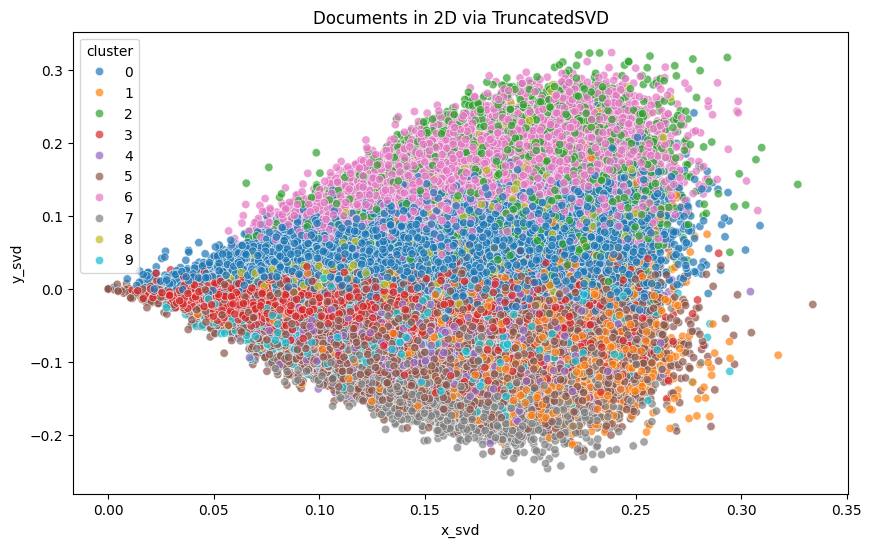

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='x_svd', 
    y='y_svd',
    hue='cluster',   # or 'topic' if using LDA
    data=df,
    palette='tab10',
    legend='full',
    alpha=0.7
)
plt.title("Documents in 2D via TruncatedSVD")
plt.show()

# Dimentionality Reduction: t-SNE

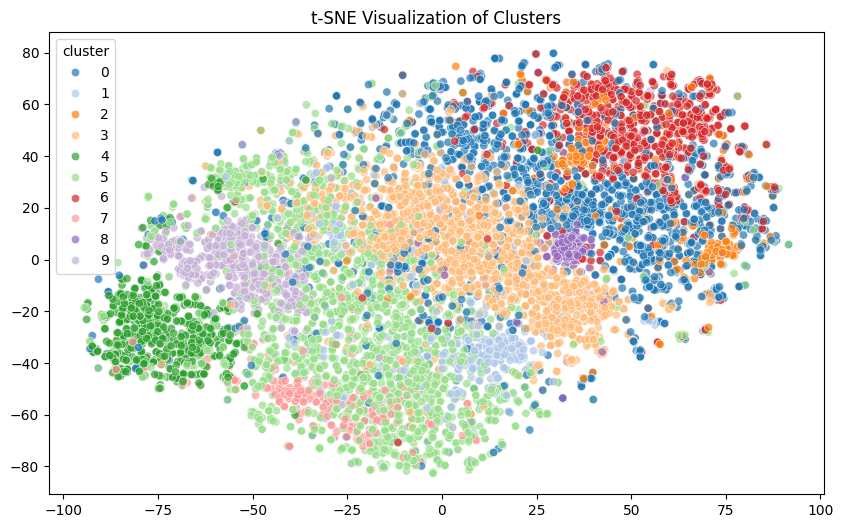

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: t-SNE for Dimensionality Reduction
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embeddings = tsne_model.fit_transform(tfidf_matrix.toarray())  # Convert sparse matrix to dense

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=tsne_embeddings[:, 0],
    y=tsne_embeddings[:, 1],
    hue=df['cluster'],  # Assuming 'cluster' column contains cluster labels
    palette='tab20',
    legend='full',
    alpha=0.7
)
plt.title("t-SNE Visualization of Clusters")
plt.show()